##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [3]:
!pip install mediapipe

You should consider upgrading via the 'C:\UX\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [4]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Visualization utilities

In [5]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import cv2

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

In [6]:
!wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.jpg")
cv2_imshow(img)

'wget' is not recognized as an internal or external command,
operable program or batch file.


ModuleNotFoundError: No module named 'google.colab'

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

if len(uploaded.keys()):
   IMAGE_FILE = next(iter(uploaded))
   print('Uploaded file:', IMAGE_FILE)

Saving WIN_20250212_10_22_37_Pro.jpg to WIN_20250212_10_22_37_Pro.jpg
Uploaded file: WIN_20250212_10_22_37_Pro.jpg


## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import cv2

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("Te.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# Convert from RGB to BGR
bgr_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Show the image
cv2.imshow("Annotated Image", bgr_image)

In [ ]:
import mediapipe as mp
import time
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

def draw_image(image):
    detection_result = detector.detect(image)
    annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
    return annotated_image


input_video_path = "input.mp4"
cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define output video writer
output_video_path = "output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))


frame_count = 0
start_time = time.time()  # Start measuring time



# Process video frame by frame
while cap.isOpened():
    isreadable, frame = cap.read()
    if not isreadable:
        break
    frame_count += 1
    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    annotated_frame = draw_image(mp_image)
    out.write(annotated_frame)
    if frame_count >= fps:
      elapsed_time = time.time() - start_time  # Time taken to render 1 second of video
      print(f"Speed of render: {elapsed_time:.2f} sec")

      frame_count = 0  # Reset frame counter
      start_time = time.time()  # Reset timer


# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

Speed of render: 2.50 sec
Speed of render: 2.00 sec
Speed of render: 1.52 sec
Speed of render: 1.62 sec


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


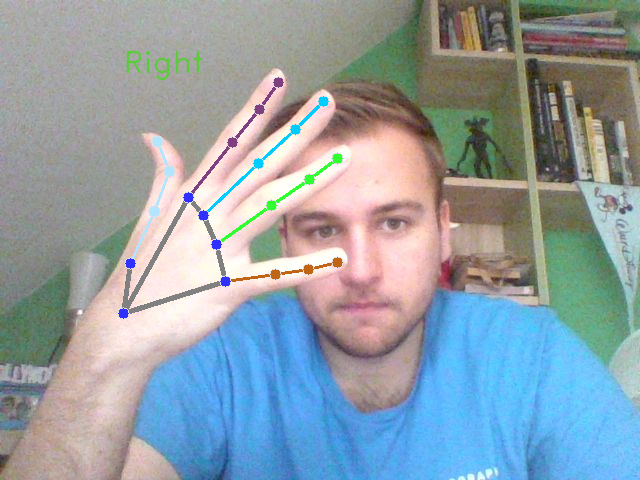

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  annotated_image = draw_image(mp.Image.create_from_file(filename))
  cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from base64 import b64decode, b64encode
from PIL import Image
from io import BytesIO
from IPython.display import display, Javascript
from google.colab.output import eval_js
import cv2
import numpy as np

def capture_video_frame():
    js = Javascript('''
        async function captureFrame() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            return canvas.toDataURL('image/jpeg');
        }
    ''')
    display(js)
    data = eval_js('captureFrame()')
    binary = b64decode(data.split(',')[1])
    print("Ds")
    return binary

def apply_filter(image_data):
    # Load image with OpenCV
    nparr = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Apply grayscale filter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Convert back to BGR (optional, for consistent 3-channel output)
    processed_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    return processed_img

def display_image(image):
    _, im_arr = cv2.imencode('.jpg', image)  # Encode image as JPEG
    im_bytes = im_arr.tobytes()

    im_b64 = b64encode(im_bytes).decode('utf-8')
    print("ss")
    display(Image(data=im_bytes))



In [ ]:
import cv2
import mediapipe as mp
import time
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils


def draw_scribble_with_your_finge(frame,detection_result):
    mp_hands = mp.solutions.hands
    hand_landmarks_list = detection_result.hand_landmarks
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[0]
        
        
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]

        cx, cy = int(min(x_coordinates) * 640),int(min(y_coordinates) * 480)
       
        frame[cx:100,cy:100] = 10

    return frame 


    
# Initialize the video capture object
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()


panel= np.full((480,640), 255, dtype=np.uint8)
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    height, width, channels = frame.shape
    if not ret:
        print("Error: Failed to capture image.")
        break
    bbox_array = np.zeros([height,width,4], dtype=np.uint8)    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    annotated_frame = draw_image(mp_image)
    detection_result = detector.detect(mp_image)
    #panel = draw_scribble_with_your_finge(panel, detection_result)
    bbox_array[:,:,1:4] = annotated_frame
    bbox_array [:,:,0]= panel
    cv2.imshow('Camera Feed', bbox_array)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


NameError: name 'draw_image' is not defined